In [2]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [3]:
import os
import keras
import math
import numpy as np
from keras import regularizers
from keras.datasets import cifar10
from keras.constraints import max_norm
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras import optimizers
from keras import initializers
from matplotlib import pyplot as plt
#% matplotlib inline

In [4]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 200
l = 32
num_filter = 12
compression = 0.5
dropout_rate = 0.2

# kernel regularization for controlling variance
reg = regularizers.l2(1e-4)

# kernel initializer following the densenet paper
init = 'he_uniform'

# momentum for SGD optimizer
momentum_sgd = 0.90


In [6]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]


# convert y to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



In [7]:
# convert the type of x_train and x_test to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# data manipulation and standardization to less than 1
x_train /= 255.0
x_test /= 255.0


0


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


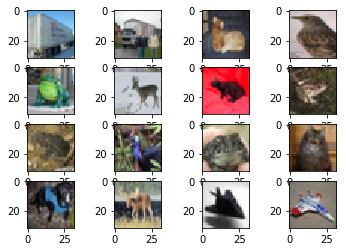

In [8]:
# Visualize a few examples


start_num = 0 
print(start_num)
for i in range(start_num, start_num+16):
  for sub_plot in range(0, 16):
    plt.subplot(4, 4, 1 + sub_plot)
    
    plt.imshow(x_train[i+sub_plot], interpolation='none')
plt.show()


In [9]:
# Use Image Data Generator for image augmentation
from keras.preprocessing.image import ImageDataGenerator

# image data generator object
datagen = ImageDataGenerator(horizontal_flip=True, 
                             width_shift_range=0.10, 
                             height_shift_range=0.10,
                             )
# fit parameters from data
datagen.fit(x_train) 


In [10]:
# Dense Block
def add_denseblock(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False, padding='same', kernel_initializer=init, kernel_regularizer=reg)(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
                
    return temp

In [11]:
def add_transition(input, num_filter = num_filter, dropout_rate = dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same', kernel_initializer=init, kernel_regularizer=reg)(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [12]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(BatchNorm)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax',kernel_initializer=init, kernel_regularizer=reg)(flat)
    
    return output

In [13]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False, padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Fourth_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
Fourth_Transition = add_transition(Fourth_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Fourth_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [14]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
# create a very simple learning schedule
# Create a function for step decay in learning rate based on epochs
def simple_decay(epoch):
  initial_lrate = 0.1
  
  if epoch <= 100:
    sim_lr = initial_lrate
  elif  (100 < epoch <= 150):
    sim_lr = initial_lrate/10.0
  else:
    sim_lr = initial_lrate/100.0
      
  return sim_lr

In [16]:
lrate = LearningRateScheduler(simple_decay)

In [17]:
# set up SGD optimizer with momentum
# set decay and learning rate as zero, implement the rate changes through a callback
optim = optimizers.SGD(lr=0.0, momentum=momentum_sgd, decay=1e-4, nesterov=True)

In [18]:
# checkpoint for saving weights whenever val acc increases
from keras.callbacks import ModelCheckpoint
filepath="lastl2-aug-dropout-weights-improvement-{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint_dir = os.path.dirname(filepath)
# set up checkpoint to save weights whenever validation accuracy improves
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [19]:
callbacks_list = [checkpoint, lrate]

In [20]:
# compile the model using cross entropy loss and the SGD optimizer set up above
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=(x_train.shape[0] // batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list,
                        verbose=1)

Epoch 1/200
781/781 [==============================] - 238s 304ms/step - loss: 2.2169 - acc: 0.2501 - val_loss: 2.1323 - val_acc: 0.2739

Epoch 00001: val_acc improved from -inf to 0.27390, saving model to lastl2-aug-dropout-weights-improvement-001-0.2739.hdf5
Epoch 2/200
781/781 [==============================] - 185s 236ms/step - loss: 1.8921 - acc: 0.3632 - val_loss: 1.8248 - val_acc: 0.4067

Epoch 00002: val_acc improved from 0.27390 to 0.40670, saving model to lastl2-aug-dropout-weights-improvement-002-0.4067.hdf5
Epoch 3/200
781/781 [==============================] - 185s 237ms/step - loss: 1.6888 - acc: 0.4373 - val_loss: 1.6657 - val_acc: 0.4589

Epoch 00003: val_acc improved from 0.40670 to 0.45890, saving model to lastl2-aug-dropout-weights-improvement-003-0.4589.hdf5
Epoch 4/200
781/781 [==============================] - 184s 235ms/step - loss: 1.5234 - acc: 0.4978 - val_loss: 1.6599 - val_acc: 0.4889

Epoch 00004: val_acc improved from 0.45890 to 0.48890, saving model to la

781/781 [==============================] - 184s 236ms/step - loss: 0.6664 - acc: 0.8292 - val_loss: 1.1540 - val_acc: 0.7369

Epoch 00040: val_acc did not improve from 0.82390
Epoch 41/200
781/781 [==============================] - 190s 243ms/step - loss: 0.6632 - acc: 0.8293 - val_loss: 1.1164 - val_acc: 0.7436

Epoch 00041: val_acc did not improve from 0.82390
Epoch 42/200
781/781 [==============================] - 187s 240ms/step - loss: 0.6548 - acc: 0.8332 - val_loss: 1.0117 - val_acc: 0.7668

Epoch 00042: val_acc did not improve from 0.82390
Epoch 43/200
781/781 [==============================] - 188s 241ms/step - loss: 0.6580 - acc: 0.8314 - val_loss: 0.7276 - val_acc: 0.8284

Epoch 00043: val_acc improved from 0.82390 to 0.82840, saving model to lastl2-aug-dropout-weights-improvement-043-0.8284.hdf5
Epoch 44/200
781/781 [==============================] - 186s 238ms/step - loss: 0.6374 - acc: 0.8393 - val_loss: 0.7886 - val_acc: 0.8209

Epoch 00044: val_acc did not improve from 

781/781 [==============================] - 185s 237ms/step - loss: 0.5248 - acc: 0.8718 - val_loss: 0.6508 - val_acc: 0.8573

Epoch 00081: val_acc did not improve from 0.86360
Epoch 82/200
781/781 [==============================] - 186s 238ms/step - loss: 0.5277 - acc: 0.8724 - val_loss: 0.8283 - val_acc: 0.8214

Epoch 00082: val_acc did not improve from 0.86360
Epoch 83/200
781/781 [==============================] - 185s 237ms/step - loss: 0.5201 - acc: 0.8733 - val_loss: 0.9265 - val_acc: 0.8103

Epoch 00083: val_acc did not improve from 0.86360
Epoch 84/200
781/781 [==============================] - 184s 236ms/step - loss: 0.5166 - acc: 0.8743 - val_loss: 0.8023 - val_acc: 0.8080

Epoch 00084: val_acc did not improve from 0.86360
Epoch 85/200
781/781 [==============================] - 186s 238ms/step - loss: 0.5204 - acc: 0.8744 - val_loss: 0.6954 - val_acc: 0.8393

Epoch 00085: val_acc did not improve from 0.86360
Epoch 86/200
781/781 [==============================] - 185s 236ms/s

781/781 [==============================] - 186s 238ms/step - loss: 0.3648 - acc: 0.9215 - val_loss: 0.5290 - val_acc: 0.8934

Epoch 00122: val_acc did not improve from 0.89740
Epoch 123/200
781/781 [==============================] - 184s 236ms/step - loss: 0.3615 - acc: 0.9211 - val_loss: 0.5528 - val_acc: 0.8907

Epoch 00123: val_acc did not improve from 0.89740
Epoch 124/200
781/781 [==============================] - 185s 237ms/step - loss: 0.3610 - acc: 0.9224 - val_loss: 0.5241 - val_acc: 0.8945

Epoch 00124: val_acc did not improve from 0.89740
Epoch 125/200
174/781 [=====>........................] - ETA: 2:17 - loss: 0.3652 - acc: 0.9221

In [ ]:
# reloading weights and continuinuing training as SSH connection issues disconnected notebook
# including initial epoch as 120 and epochs = 200 to restart training from the checkpointed epoch with appropriate weights
model.load_weights('lastl2-aug-dropout-weights-improvement-120-0.8974.hdf5')

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=(x_train.shape[0] // batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list,
                        initial_epoch=120,
                        verbose=1)

Epoch 121/200
781/781 [==============================] - 188s 241ms/step - loss: 0.4495 - acc: 0.8928 - val_loss: 0.6526 - val_acc: 0.8592

Epoch 00121: val_acc improved from -inf to 0.85920, saving model to lastl2-aug-dropout-weights-improvement-121-0.8592.hdf5
Epoch 122/200
781/781 [==============================] - 185s 237ms/step - loss: 0.4531 - acc: 0.8920 - val_loss: 0.7175 - val_acc: 0.8427

Epoch 00122: val_acc did not improve from 0.85920
Epoch 123/200
781/781 [==============================] - 185s 237ms/step - loss: 0.4489 - acc: 0.8943 - val_loss: 0.6096 - val_acc: 0.8644

Epoch 00123: val_acc improved from 0.85920 to 0.86440, saving model to lastl2-aug-dropout-weights-improvement-123-0.8644.hdf5
Epoch 124/200
781/781 [==============================] - 185s 236ms/step - loss: 0.4395 - acc: 0.8963 - val_loss: 0.5713 - val_acc: 0.8731

Epoch 00124: val_acc improved from 0.86440 to 0.87310, saving model to lastl2-aug-dropout-weights-improvement-124-0.8731.hdf5
Epoch 125/200
7

In [21]:
# reloading weights and continuinuing training as SSH connection issues disconnected notebook again
# including initial epoch as 144 and epochs = 200 to restart training from the checkpointed epoch with appropriate weights
model.load_weights('lastl2-aug-dropout-weights-improvement-144-0.9009.hdf5')

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=(x_train.shape[0] // batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list,
                        initial_epoch=144,
                        verbose=1)

Epoch 145/200
781/781 [==============================] - 237s 304ms/step - loss: 0.4494 - acc: 0.8887 - val_loss: 0.5602 - val_acc: 0.8744

Epoch 00145: val_acc improved from -inf to 0.87440, saving model to lastl2-aug-dropout-weights-improvement-145-0.8744.hdf5
Epoch 146/200
781/781 [==============================] - 186s 238ms/step - loss: 0.4470 - acc: 0.8907 - val_loss: 0.6219 - val_acc: 0.8655

Epoch 00146: val_acc did not improve from 0.87440
Epoch 147/200
781/781 [==============================] - 184s 236ms/step - loss: 0.4385 - acc: 0.8935 - val_loss: 0.5457 - val_acc: 0.8806

Epoch 00147: val_acc improved from 0.87440 to 0.88060, saving model to lastl2-aug-dropout-weights-improvement-147-0.8806.hdf5
Epoch 148/200
781/781 [==============================] - 186s 238ms/step - loss: 0.4338 - acc: 0.8953 - val_loss: 0.5415 - val_acc: 0.8796

Epoch 00148: val_acc did not improve from 0.88060
Epoch 149/200
781/781 [==============================] - 184s 236ms/step - loss: 0.4278 - a

781/781 [==============================] - 183s 234ms/step - loss: 0.3129 - acc: 0.9347 - val_loss: 0.5068 - val_acc: 0.9003

Epoch 00184: val_acc did not improve from 0.90610
Epoch 185/200
781/781 [==============================] - 184s 235ms/step - loss: 0.3121 - acc: 0.9334 - val_loss: 0.4887 - val_acc: 0.9042

Epoch 00185: val_acc did not improve from 0.90610
Epoch 186/200
781/781 [==============================] - 185s 236ms/step - loss: 0.3123 - acc: 0.9350 - val_loss: 0.4944 - val_acc: 0.9030

Epoch 00186: val_acc did not improve from 0.90610
Epoch 187/200
781/781 [==============================] - 185s 237ms/step - loss: 0.3102 - acc: 0.9342 - val_loss: 0.4984 - val_acc: 0.9030

Epoch 00187: val_acc did not improve from 0.90610
Epoch 188/200
781/781 [==============================] - 186s 238ms/step - loss: 0.3134 - acc: 0.9337 - val_loss: 0.4936 - val_acc: 0.9040

Epoch 00188: val_acc did not improve from 0.90610
Epoch 189/200
781/781 [==============================] - 185s 23

In [22]:
# last leg of training using the learnt weights on unaugmented image data
# this includes a call back to reduce learning rate if needed and to stop training if no improvement is seen in 15 epochs

# create callbacks for learning rate reduction and for early stopping
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=15, mode='auto')

# update the callbacks list used earlier to now include these while dropping the call to the LR scheduler
callbacks_list = [checkpoint, reduce, early]

In [23]:
# fit model on unaugmented data start with initial epoch = 200 to ensure that we meet the assignment limit of 250 epochs
model.fit(x_train, y_train, 
          batch_size=batch_size, 
          epochs=250,
          validation_data=(x_test, y_test),
          callbacks=callbacks_list,
          initial_epoch=200,
          verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 201/250
50000/50000 [==============================] - 185s 4ms/step - loss: 0.2808 - acc: 0.9455 - val_loss: 0.4615 - val_acc: 0.9098

Epoch 00201: val_acc improved from 0.90690 to 0.90980, saving model to lastl2-aug-dropout-weights-improvement-201-0.9098.hdf5
Epoch 202/250
50000/50000 [==============================] - 185s 4ms/step - loss: 0.2758 - acc: 0.9466 - val_loss: 0.4640 - val_acc: 0.9097

Epoch 00202: val_acc did not improve from 0.90980
Epoch 203/250
50000/50000 [==============================] - 185s 4ms/step - loss: 0.2749 - acc: 0.9474 - val_loss: 0.4660 - val_acc: 0.9100

Epoch 00203: val_acc improved from 0.90980 to 0.91000, saving model to lastl2-aug-dropout-weights-improvement-203-0.9100.hdf5
Epoch 204/250
50000/50000 [==============================] - 185s 4ms/step - loss: 0.2715 - acc: 0.9483 - val_loss: 0.4679 - val_acc: 0.9089

Epoch 00204: val_acc did not improve from 0.91000
Epoch 205/250
50000/50000 [===

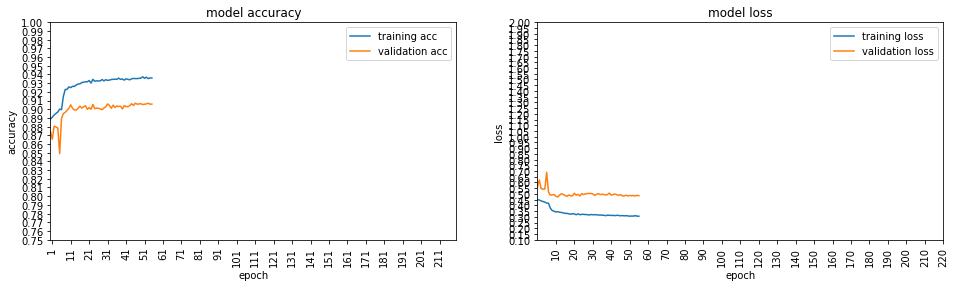

In [24]:
# Set up a subplot grid that is 1 x 2

# set up x_axis based on epochs run above, y axis is set on expected values of loss and accuracy
max_x = 220

# set the size with aspect ratio 4:1
fig = plt.figure(figsize=(16,4))
# and set the first such subplot as active.
plt.subplot(1, 2, 1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(10, (max_x+1), step=10), rotation=90)
plt.yticks(np.arange(0.75, 1.09, step=0.01))

axes = plt.gca()
axes.set_xlim([0,max_x])
axes.set_ylim([0.75, 1.00])
plt.legend(['training acc', 'validation acc'], loc='upper right')

# now set the second subplot as active, doing this will allow space between the two plots.
plt.subplot(1, 2, 2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(10, (max_x+1), step=10), rotation=90)
plt.yticks(np.arange(0.1, 2.01, step=0.05))
axes = plt.gca()
axes.set_xlim([0,max_x])
axes.set_ylim([0.10, 2.00])
plt.legend(['training loss', 'validation loss'], loc='upper right')

# actually display the two plots
plt.show()


In [ ]:
# extract the generalization error from the training run above
gen_error = []
for item in range(len(history.history['val_loss'])):
    gen_error.append(history.history['val_loss'][item]- history.history['loss'][item])
    
plt.plot(gen_error_1)

In [ ]:
# Test the best model by loading the best checkpoint
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [ ]:
#from google.colab import files

#files.download('DNST_model.h5')